## Skin Cancer Classification

### **Problem statement:**
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### **Importing Skin Cancer Data**

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [1]:
# set batch size and image size
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility. We will use 80% of the images for training, and 20% for validation.

In [ ]:
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# resizing test data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Listing out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
names = {0 : 'Actinic keratosis', 1 : 'Basal cell carcinoma', 2 : 'Dermatofibroma', 3 : 'Melanoma', 4 : 'Nevus', 5 : 'Pigented benign keratosis', 6 : 'Seborrheic keratosis', 7 : 'Squamous cell carcinoma', 8 : 'Vascular lesion'}

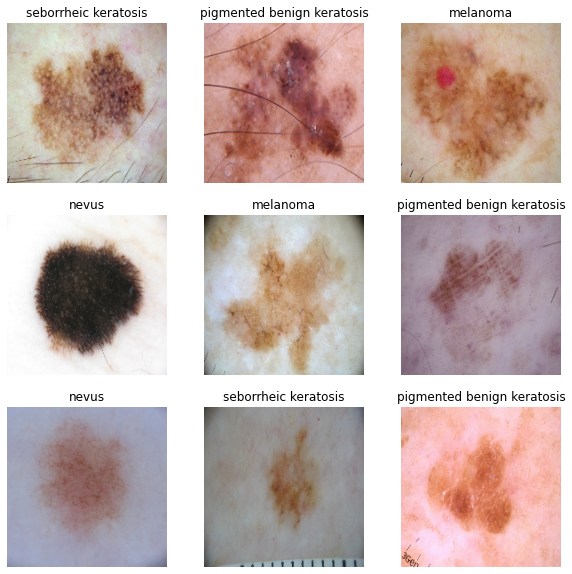

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

We will create a CNN model, which can accurately detect 9 classes present in the dataset. We will use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [ ]:
num_classes = 9

In [ ]:
# model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3))
  ])

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_height,img_width,3))) # 178
model.add(MaxPooling2D(pool_size=(2, 2))) 

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 

# third conv layer
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(512, activation='relu')) # fully connected

# softmax layer
model.add(Dense(num_classes))
#keras.utils.plot_model(model, show_shapes=True)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 29s 185ms/step - loss: 2.2215 - accuracy: 0.2104 - val_loss: 1.8744 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 5s 81ms/step - loss: 1.7626 - accuracy: 0.3722 - val_loss: 1.6193 - val_accuracy: 0.4541
Epoch 3/20
56/56 [==============================] - 4s 78ms/step - loss: 1.4782 - accuracy: 0.4933 - val_loss: 1.4272 - val_accuracy: 0.5168
Epoch 4/20
56/56 [==============================] - 4s 79ms/step - loss: 1.3264 - accuracy: 0.5312 - val_loss: 1.5157 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 4s 78ms/step - loss: 1.2475 - accuracy: 0.5569 - val_loss: 1.3930 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 4s 79ms/step - loss: 1.1719 - accuracy: 0.5809 - val_loss: 1.4780 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - loss: 1.1078 - accuracy: 0.5915 - val_loss: 1.4560 - val_accuracy: 0.5280
Epoch 8/20


### Visualizing training results

In [ ]:
def visualize_train_test_accuracy(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

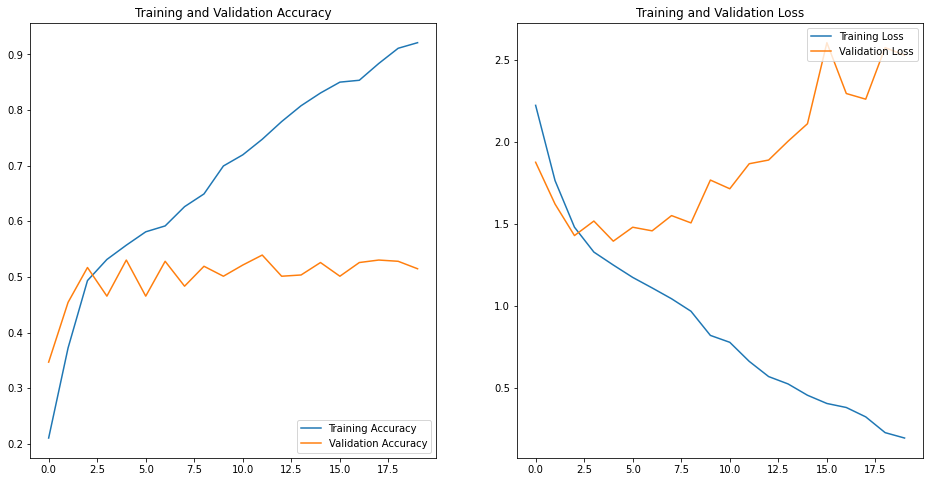

In [ ]:
visualize_train_test_accuracy(history, epochs)

### Findings: 
The model has high training accuracy (~ 90%) but the validation accuracy is very low (~ 50%). The model cannot generalize what it is learning. This is a clear sign of **overfitting**. We will add a dropout layer to tackle this issue.

### Create a model 
(Adding Dropout to vanilla model)

In [ ]:
# model
model2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3))
  ])

# first conv layer
model2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_height,img_width,3)))
model2.add(MaxPooling2D(pool_size=(2, 2))) 

# second conv layer
model2.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2))) 

# third conv layer
model2.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2))) 
model2.add(Dropout(0.5))

# flatten and put a fully connected layer
model2.add(Flatten())
model2.add(Dense(512, activation='relu')) # fully connected

# softmax layer
model2.add(Dense(num_classes))
#keras.utils.plot_model(model2, show_shapes=True)

In [ ]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 22, 22, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 11, 11, 128)      

### Compile the model

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [ ]:
epochs = 20
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 16s 125ms/step - loss: 2.0733 - accuracy: 0.2143 - val_loss: 2.1227 - val_accuracy: 0.2081
Epoch 2/20
56/56 [==============================] - 3s 50ms/step - loss: 1.8095 - accuracy: 0.3376 - val_loss: 1.9325 - val_accuracy: 0.3020
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.5844 - accuracy: 0.4369 - val_loss: 1.5150 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4122 - accuracy: 0.5061 - val_loss: 1.3733 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 1.3640 - accuracy: 0.5218 - val_loss: 1.4490 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2992 - accuracy: 0.5480 - val_loss: 1.3770 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.2624 - accuracy: 0.5513 - val_loss: 1.4360 - val_accuracy: 0.5324
Epoch 8/20


### Data Visualization

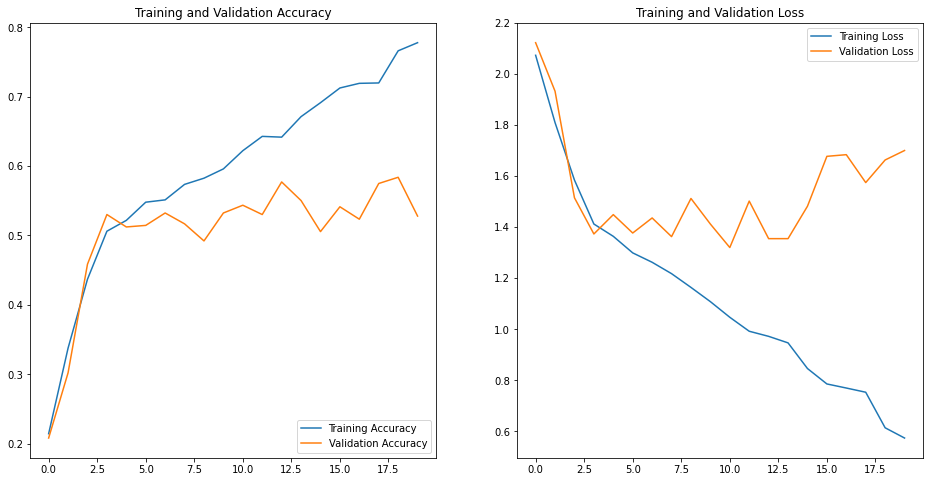

In [ ]:
visualize_train_test_accuracy(history2, epochs)

### Findings: 
- By adding Dropout layer, we were able to reduce the gap between Training and Validation accuracy and reduce the amount of Overfitting by a small margin. Also we were able to reduce Validation error. 
- In order to see more improvements, we will try adding Data Augmentation techniques.

### **Data Augmentation**

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

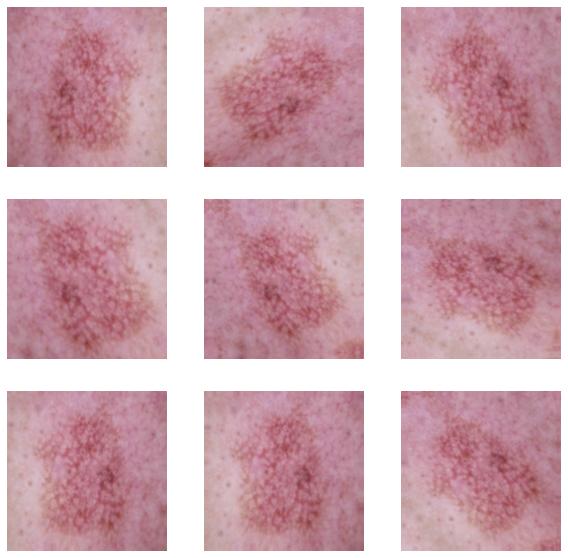

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Create the model, compile and train the model

In [ ]:
# model 3
model3 = Sequential([
        data_augmentation,
        layers.experimental.preprocessing.Rescaling(1./255)
  ])

# first conv layer
model3.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2))) 

# second conv layer
model3.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2))) 

# third conv layer
model3.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2))) 
model3.add(Dropout(0.5))

# flatten and put a fully connected layer
model3.add(Flatten())
model3.add(Dense(512, activation='relu')) # fully connected

# softmax layer
model3.add(Dense(num_classes))

In [ ]:
model3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_12 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 22, 22, 128)     

### Compiling the model

In [ ]:
#compile the model 3
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 60ms/step - loss: 1.9917 - accuracy: 0.2433 - val_loss: 1.8957 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 1.6958 - accuracy: 0.3912 - val_loss: 1.5898 - val_accuracy: 0.4855
Epoch 3/20
56/56 [==============================] - 3s 52ms/step - loss: 1.5111 - accuracy: 0.4849 - val_loss: 1.5143 - val_accuracy: 0.5168
Epoch 4/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4557 - accuracy: 0.4844 - val_loss: 1.3971 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 3s 51ms/step - loss: 1.3891 - accuracy: 0.5151 - val_loss: 1.4924 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4019 - accuracy: 0.4961 - val_loss: 1.4815 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 3s 50ms/step - loss: 1.3573 - accuracy: 0.5223 - val_loss: 1.3439 - val_accuracy: 0.5481
Epoch 8/20
56

### Visualizing the results

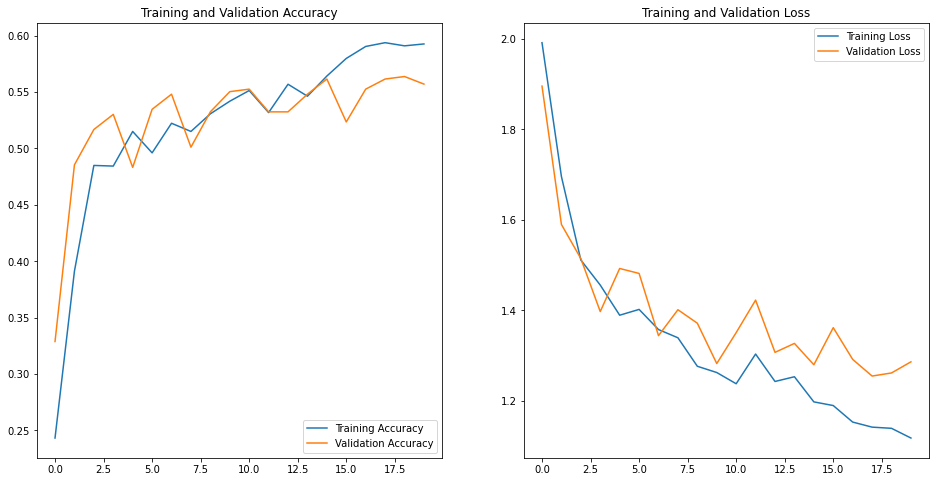

In [ ]:
visualize_train_test_accuracy(history3, epochs)

### Findings:
- After performing Data Augmentation and adding Dropouts of `0.5` to our previous model, our model is no longer is overfitting. - There is some improvement in our model, however the `accuracy` is `low`. This is a sign of `underfitting`. We suspect this might be casued due to class imbalance. Let us look at the class distribution.

## **Class Distribution:** 
Find the distribution of classes in the training dataset.

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
from glob import glob

In [ ]:
# list the path for training data
path_list = [x for x in glob(os.path.join(data_dir_train, '*/*.jpg'))]
path_list

['D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer 2\\Train\\actinic keratosis\\ISIC_0025780.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer 2\\Train\\actinic keratosis\\ISIC_0025803.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer 2\\Train\\actinic keratosis\\ISIC_0025825.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer 2\\Train\\actinic keratosis\\ISIC_0025953.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer 2\\Train\\actinic keratosis\\ISIC_0025957.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer 2\\Train\\actinic keratosis\\ISIC_0025992.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer 2\\Train\\actinic keratosis\\ISIC_0026040.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer 2\\Train\\actinic keratosis\\ISIC_0026149.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer 2\\Train\\actinic keratosis\\ISIC_0026171.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer 2\\Train\\actinic keratosis\\ISIC_0026194.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer 2\\

In [ ]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*/*.jpg'))]
lesion_list

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
# create dictionary of path and it's label
dataframe_dict_new = dict(zip(path_list, lesion_list))

In [ ]:
#Create dataframe
df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
print(df)

                                                   Path              Label
0     D:\Upgrad\ML2\CNN Assignment\Skin Cancer 2\Tra...  actinic keratosis
1     D:\Upgrad\ML2\CNN Assignment\Skin Cancer 2\Tra...  actinic keratosis
2     D:\Upgrad\ML2\CNN Assignment\Skin Cancer 2\Tra...  actinic keratosis
3     D:\Upgrad\ML2\CNN Assignment\Skin Cancer 2\Tra...  actinic keratosis
4     D:\Upgrad\ML2\CNN Assignment\Skin Cancer 2\Tra...  actinic keratosis
...                                                 ...                ...
2234  D:\Upgrad\ML2\CNN Assignment\Skin Cancer 2\Tra...    vascular lesion
2235  D:\Upgrad\ML2\CNN Assignment\Skin Cancer 2\Tra...    vascular lesion
2236  D:\Upgrad\ML2\CNN Assignment\Skin Cancer 2\Tra...    vascular lesion
2237  D:\Upgrad\ML2\CNN Assignment\Skin Cancer 2\Tra...    vascular lesion
2238  D:\Upgrad\ML2\CNN Assignment\Skin Cancer 2\Tra...    vascular lesion

[2239 rows x 2 columns]


In [ ]:
# Create list of classes and the count of images
data = []
for class_name in class_names:
    image_count = len(list(data_dir_train.glob(class_name + '/*.jpg')))
    data.append([class_name, image_count])

In [ ]:
#Create dataframe
class_distrib = pd.DataFrame(data, columns = ['Name', 'Count'])
print(class_distrib)

                         Name  Count
0           actinic keratosis    114
1        basal cell carcinoma    376
2              dermatofibroma     95
3                    melanoma    438
4                       nevus    357
5  pigmented benign keratosis    462
6        seborrheic keratosis     77
7     squamous cell carcinoma    181
8             vascular lesion    139


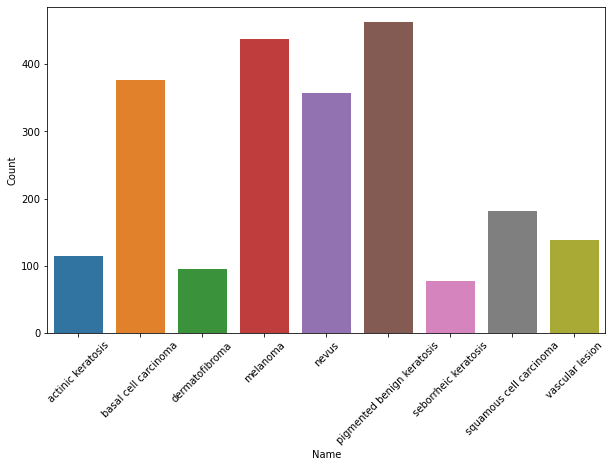

In [ ]:
# graph to visualize distribution of data
fig = plt.figure(figsize=(10,6))
sns.barplot(x = 'Name', y = 'Count', data = class_distrib)
plt.xticks(rotation=45)
plt.show()

### Findings:
We observe that our data is highly skewed and has imbalance. We will need to fix this by appropriate data Augmentation technique

- The 'Seborrheic Keratosis' has the least number of samples - 77
- The 'Melanoma' and 'Pigmented Benign Keratosis' dominate the data with more than 400 samples.
- 'Seborrheic Keratosis' and 'Actinic Keratosis' have less than 100 samples.

### **Rectify the class imbalance**
We will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=195fd3dd23cf0e3fc0f1687e7a08332019624b673987583aac39fc3ccf84fa91
  Stored in directory: c:\users\jordan\appdata\local\pip\cache\wheels\8e\70\28\3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built future


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="./Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

In [ ]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to D:/Upgrad/ML2/CNN Assignment/Skin Cancer/Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x25B764752E0>: 100%|█| 500/500 [00:04<00:


Initialised with 376 image(s) found.
Output directory set to D:/Upgrad/ML2/CNN Assignment/Skin Cancer/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25B7C4D2460>: 100%|█| 500/500 [00:04<00:00, 123.42 Samples


Initialised with 95 image(s) found.
Output directory set to D:/Upgrad/ML2/CNN Assignment/Skin Cancer/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25B7649C5B0>: 100%|█| 500/500 [00:03<00:00, 125.77 Samples


Initialised with 438 image(s) found.
Output directory set to D:/Upgrad/ML2/CNN Assignment/Skin Cancer/Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x25B764655B0>: 100%|█| 500/500 [00:15<00:


Initialised with 357 image(s) found.
Output directory set to D:/Upgrad/ML2/CNN Assignment/Skin Cancer/Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x25B76469070>: 100%|█| 500/500 [00:14<0


Initialised with 462 image(s) found.
Output directory set to D:/Upgrad/ML2/CNN Assignment/Skin Cancer/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25B7C876A90>: 100%|█| 500/500 [00:03<00:00, 138.74 Samples


Initialised with 77 image(s) found.
Output directory set to D:/Upgrad/ML2/CNN Assignment/Skin Cancer/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x25B0739D3D0>: 100%|█| 500/500 [00:07<00:00, 68.79 Samples


Initialised with 181 image(s) found.
Output directory set to D:/Upgrad/ML2/CNN Assignment/Skin Cancer/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25B7C4D21C0>: 100%|█| 500/500 [00:03<00:00, 140.20 Samples


Initialised with 139 image(s) found.
Output directory set to D:/Upgrad/ML2/CNN Assignment/Skin Cancer/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25B7C873460>: 100%|█| 500/500 [00:03<00:00, 141.94 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_09cebbfa-ffeb-4f20-89a5-04b564d359d7.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0d41633c-0d90-4ce7-99c4-c210864e3e74.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_22b7c304-e18e-4239-967d-4d1fed167408.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_495ad432-3079-49a9-b014-2136badb9073.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_968e2af6-c735-4c77-be4d-67f501b67803.jpg',
 'D:\\Upgrad\\ML2\\CNN Assignment\\Skin Cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_99b912bf-7e06-430e-ba8a-d4547

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
print(df2)
new_df = df.append(df2)

                                                   Path              Label
0     D:\Upgrad\ML2\CNN Assignment\Skin Cancer\Train...  actinic keratosis
1     D:\Upgrad\ML2\CNN Assignment\Skin Cancer\Train...  actinic keratosis
2     D:\Upgrad\ML2\CNN Assignment\Skin Cancer\Train...  actinic keratosis
3     D:\Upgrad\ML2\CNN Assignment\Skin Cancer\Train...  actinic keratosis
4     D:\Upgrad\ML2\CNN Assignment\Skin Cancer\Train...  actinic keratosis
...                                                 ...                ...
4495  D:\Upgrad\ML2\CNN Assignment\Skin Cancer\Train...    vascular lesion
4496  D:\Upgrad\ML2\CNN Assignment\Skin Cancer\Train...    vascular lesion
4497  D:\Upgrad\ML2\CNN Assignment\Skin Cancer\Train...    vascular lesion
4498  D:\Upgrad\ML2\CNN Assignment\Skin Cancer\Train...    vascular lesion
4499  D:\Upgrad\ML2\CNN Assignment\Skin Cancer\Train...    vascular lesion

[4500 rows x 2 columns]


In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [ ]:
data_dir_train="./Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model 4

In [ ]:
# model 4
model4 = Sequential([
        data_augmentation,
        layers.experimental.preprocessing.Rescaling(1./255),
  ])

# first conv layer
model4.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2))) 

# second conv layer
model4.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2))) 

# third conv layer
model4.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2))) 
model4.add(Dropout(0.5))

# flatten and put a fully connected layer
model4.add(Flatten())
model4.add(Dense(512, activation='relu')) # fully connected

# softmax layer
model4.add(Dense(num_classes))

In [ ]:
model4.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_14 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 45, 45, 128)     

In [ ]:
#compile the model 4
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Training the model

In [ ]:
epochs = 50

history4 = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 69s 382ms/step - loss: 2.0036 - accuracy: 0.2600 - val_loss: 1.9847 - val_accuracy: 0.3482
Epoch 2/50
169/169 [==============================] - 29s 167ms/step - loss: 1.5513 - accuracy: 0.4114 - val_loss: 1.4165 - val_accuracy: 0.4581
Epoch 3/50
169/169 [==============================] - 28s 166ms/step - loss: 1.4474 - accuracy: 0.4445 - val_loss: 1.4816 - val_accuracy: 0.4254
Epoch 4/50
169/169 [==============================] - 28s 164ms/step - loss: 1.3711 - accuracy: 0.4761 - val_loss: 1.3982 - val_accuracy: 0.4878
Epoch 5/50
169/169 [==============================] - 28s 164ms/step - loss: 1.3026 - accuracy: 0.5007 - val_loss: 1.2207 - val_accuracy: 0.5360
Epoch 6/50
169/169 [==============================] - 28s 162ms/step - loss: 1.2467 - accuracy: 0.5159 - val_loss: 1.1627 - val_accuracy: 0.5494
Epoch 7/50
169/169 [==============================] - 28s 164ms/step - loss: 1.2325 - accuracy: 0.5256 - val_loss: 1.1648 - val_ac

####  Visualize the model results

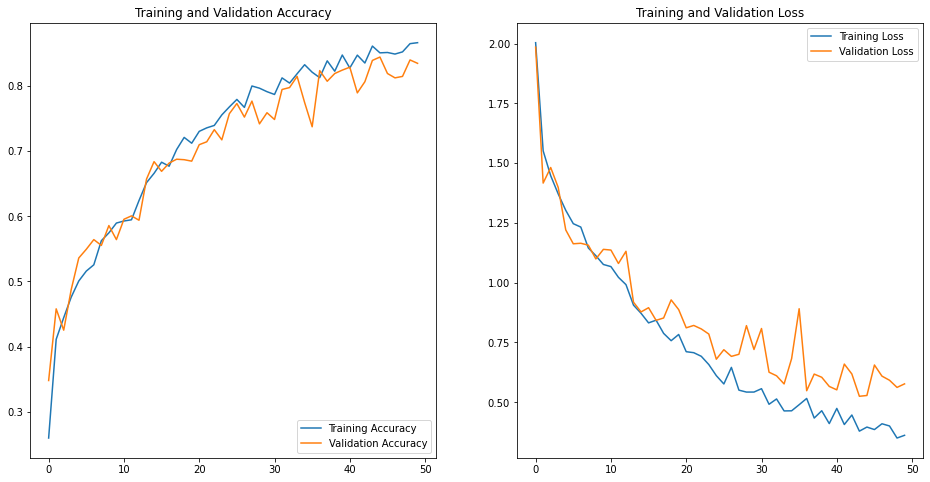

In [ ]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:
- We successfully removed the `overfitting problem` with `Data Augmentation`.
- We also solved the problem of `underfitting` using `Class Rebalance`.
- At 30 epochs, we achieved a training accuracy of `79%` and validation accuracy of `75%`.
- At 50 epochs, we achieved a training accuracy of `86%` and validation accuracy of `83%`.